# A1 - Building a Model for the Synthesis of Tabular Healthcare Data
- **Nome:** Kristhian André Oliveira Aguilar
- **Matrícula:** 298976

O objetivo deste trabalho é desenvolver um modelo capaz de gerar dados tabulares de saúde de forma **realista**, com foco em exames de hemograma. Consideramos realista a combinação de dois níveis de conhecimento [1]. O primeiro, chamado **extrínseco**, refere-se à preservação da estrutura dos dados originais: mesmas colunas, tipos e domínios válidos de valores. O segundo, denominado **intrínseco**, envolve a captura de padrões mais complexos, como distribuições conjuntas e correlações entre variáveis.

No caso do hemograma, isso significa que os dados sintetizados devem respeitar limites fisiológicos (por exemplo, não produzir idades negativas ou valores irreais de plaquetas como 0 × 10³/μL) e também refletir relações conhecidas, como a contagem de plaquetas geralmente maior em crianças do que em adultos. A preservação dessas relações será utilizada como critério de avaliação da qualidade dos dados gerados.

## Metodologia

### Imports e aquisição dos dados

As bibliotecas necessárias para este trabalho são:
- `pandas` para manipulação de dados tabulares,
- `numpy` para operações numéricas,
- `matplotlib` e `seaborn` para visualização de dados
- `ipywidgets` para interatividade.
- `scipy` para estatísticas avançadas.
- `sdv` para geração de dados sintéticos e avaliação de qualidade.

In [1]:
!pip install sdv

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats

from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import SingleTableMetadata
from sdmetrics.column_pairs import ContingencySimilarity, CorrelationSimilarity
from sdv.evaluation.single_table import evaluate_quality
from sdv.evaluation.single_table import run_diagnostic

Abaixo está o código para aquisição dos dados. Estes consistem em três arquivos CSV, todos com sem cabeçalho. Após análise dos dados, foi determinado a representação de cada coluna, da esquerda para a direita, como:

- `timestamp`: Data e hora da coleta do hemograma. Tipo `datetime64[ns]`
- `age`: Idade do paciente em anos. Tipo `int`
- `id`: Identificador único do paciente. Tipo `str`
- `sex`: Sexo do paciente (M ou F). Tipo `category`
- `analyte`: Nome do exame realizado. Tipo `category`
- `value`: Valor do exame. Com exceção dos campos de observação que foram removidos, os valores são do tipo `float64`. Assumiu-se que cada os valores observados estão em unidades padrão, como `10³/μL` para plaquetas e leucócitos, e `g/dL` para hemoglobina.


No código abaixo, os três arquivos CSV são lidos e concatenados em um único DataFrame. As colunas são renomeadas para facilitar a manipulação e análise dos dados. Além disso, as colunas de observação foram removidas, pois estavam vazias.

In [3]:
main_category_map = {
    "PLAQUETAS SANGUE": "platelets",
    "NEUTRÓFILOS ABSOLUTO": "neut_abs",
    "NEUTRÓFILOS %": "neut_pct",
    "NEUTRÓFILOS SEGMENTADOS %": "neut_segmented_pct",
    "LINFÓCITOS ABSOLUTO": "lym_abs",
    "LINFÓCITOS %": "lym_pct",
    "LINFOCITOS ATIPICOS TOTAL %": "lym_atypical_pct",
    "LEUCÓCITOS TOTAIS": "wbc_total",
    "EOSINÓFILOS ABSOLUTO": "eos_abs",
    "LUC ABSOLUTO": "luc_abs",
    "LUC %": "luc_pct",
    "PLASMÓCITOS ABSOLUTO": "pc_abs",
    "PLASMÓCITOS%": "pc_pct",
    "MCHC": "mchc",
    "OBSERVAÇÃO WBC": "obsservation_wbc",
    "OBSERVAÇÃO RBC": "observation_rbc",
    "OBSERVAÇÃO PLT": "observation_plt",
}

dataframes = []
for file in ['data1.csv', 'data2.csv', 'data3.csv']:
    df = pd.read_csv(file, header=None, 
                     names=['timestamp', 'age', 'id', 'sex', 'analyte', 'value'],
                     dtype={
                         'timestamp': 'str',
                         'age': 'int',
                         'id': 'str',
                         'sex': 'category',
                        'analyte': 'str',
                            'value': 'str'
                     })
    dataframes.append(df)
    
df = pd.concat(dataframes, ignore_index=True)

# switch the id column position with the age column
df = df[['timestamp', 'id', 'age', 'sex', 'analyte', 'value']]

# for the str camps to be strictly strings, we convert the 'value' column to string type
df['value'] = df['value'].astype(str)

df['value'] = df['value'].str.replace(',', '.', regex=False)

# remove rows that contain 'nan', or only spaces in the 'value' column
df = df[~df['value'].str.strip().isin(['nan', ''])]

# # convert 'value' column to float, coercing errors to NaN
df['value'] = pd.to_numeric(df['value'])

# remove rows where 'value' is NaN
df = df.dropna(subset=['value'])

df['analyte'] = df['analyte'].map(main_category_map).astype('category')

# convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# sort by timestamp and id
df = df.sort_values(by=['timestamp', 'id']).reset_index(drop=True)

### Escolha de variável para síntese

A fim de simplificar o processo de síntese, foi escolhida a variável `platelets` (plaquetas) como alvo. Ela foi escolhida por ser a variável mais frequente entre os exames realizados, conforme mostrado no gráfico abaixo. Além disso, é a variável mais independente já que não depende diretamente de nenhum outro tipo de exame, o que facilita a modelagem.

#### Figura 1

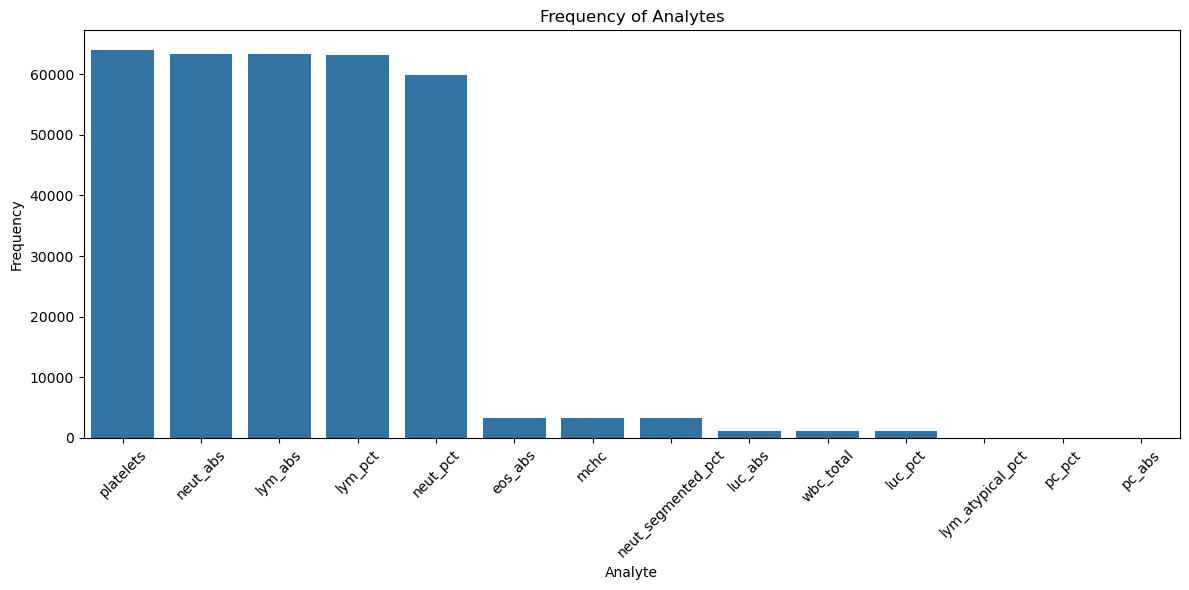

In [4]:
# plot frequency of each analyte
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='analyte', order=df['analyte'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Frequency of Analytes')
plt.xlabel('Analyte')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [5]:
df = df[df['analyte'] == 'platelets']

### Limpeza e preprocessamento dos dados

#### Remoção de amostras duplicadas

Uma exploração inicial dos dados revelou uma quantidade significativa de valores duplicados. 1013 amostras com o mesmo `id` e `timestamp` foram encontradas e removidas. Além disso, as figura 2 mostram uma grande quantidade de exames com mesmo `id` feitos dentro de um intervalo de 1 hora. Isto sugere que muitos pacientes realizaram múltiplos exames em um curto período de tempo, o que é possível no caso de pacientes internados ou com condições de saúde que exigem monitoramento frequente. No entanto, a figura 3 mostra que há registros de pacientes com 3 ou mais exames feitos em um intervalo de 1 hora, o que é considerado anômalo. Para evitar a geração de dados sintéticos com essas características, esses registros foram removidos.

In [6]:
# remove duplicates
previous_length = len(df)
df = df.drop_duplicates(subset=['id', 'timestamp'])
if len(df) < previous_length:
    print(f"Removed {previous_length - len(df)} duplicate rows.")

Removed 543 duplicate rows.


##### Figura 2

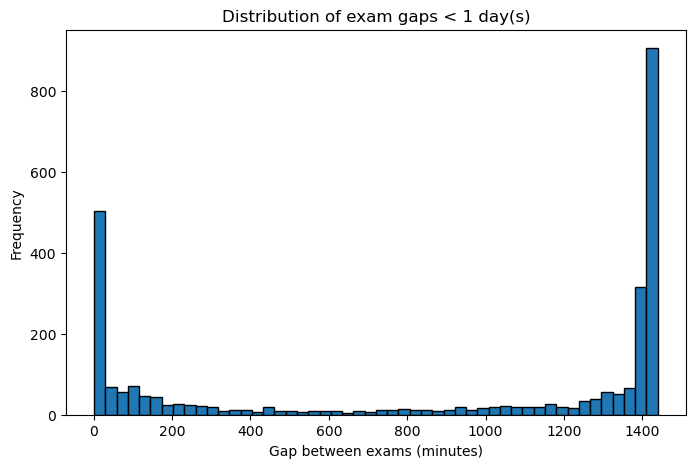

In [7]:
def assign_exam_groups(
    df: pd.DataFrame, time_threshold: pd.Timedelta | None = None
) -> pd.DataFrame:
    """
    Assigns exam group IDs for each patient.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'id' and 'timestamp' columns.
    time_threshold : pd.Timedelta or None
        If None, groups by exact timestamp.
        If set, groups consecutive rows for the same patient
        when the gap is <= time_threshold.
    
    Returns
    -------
    pd.DataFrame
        Original DataFrame with 'exam_group' and 'global_exam_id' columns.
    """
    df = df.sort_values(["id", "timestamp"]).copy()

    if time_threshold is None:
        # Exact timestamp grouping
        df["exam_group"] = df.groupby(["id", "timestamp"], sort=False).ngroup()
    else:
        # Time threshold grouping
        df["new_exam"] = (
            df.groupby("id")["timestamp"]
            .diff()
            .gt(time_threshold)
            .fillna(True)
        )
        df["exam_group"] = df.groupby("id")["new_exam"].cumsum().astype(int)
        df = df.drop(columns="new_exam")

    # Create a global exam ID string
    df["global_exam_id"] = (
        df["id"].astype(str) + "_" + df["exam_group"].astype(str)
    )

    return df

def exam_time_gaps(df_grouped: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates time differences between consecutive exams for each patient
    from a DataFrame that already has 'exam_group'.
    """
    # Get the first timestamp of each exam
    exam_times = (
        df_grouped.groupby(["id", "exam_group"])["timestamp"]
        .min()
        .reset_index()
        .sort_values(["id", "timestamp"])
    )

    # Calculate time difference between consecutive exams
    exam_times["time_diff"] = exam_times.groupby("id")["timestamp"].diff()

    return exam_times


def plot_small_gaps(exam_times: pd.DataFrame, max_days: int = 1):
    """
    Plots histogram of time differences up to max_days.
    """
    small_gaps = exam_times["time_diff"].dropna()
    small_gaps = small_gaps[small_gaps < pd.Timedelta(days=max_days)]
    small_gaps_minutes = small_gaps.dt.total_seconds() / 60

    plt.figure(figsize=(8, 5))
    plt.hist(small_gaps_minutes, bins=50, edgecolor="black")
    plt.xlabel("Gap between exams (minutes)")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of exam gaps < {max_days} day(s)")
    plt.show()

# 1. Group exams (exact timestamp)
df_grouped = assign_exam_groups(df, time_threshold=None)

# 2. Calculate time gaps
gaps_df = exam_time_gaps(df_grouped)

# 3. Inspect stats
# 4. Plot small gaps
plot_small_gaps(gaps_df, max_days=1)

##### Figura 3

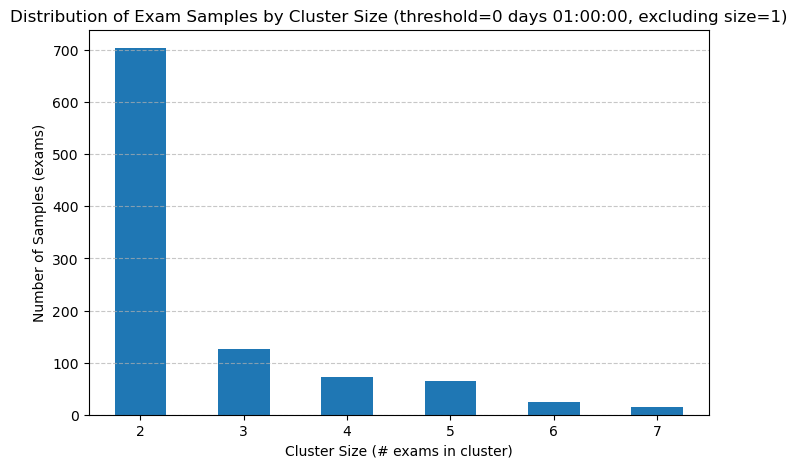

In [8]:
def plot_cluster_sample_distribution(
    df: pd.DataFrame, time_threshold: pd.Timedelta = pd.Timedelta(hours=1)
):
    """
    Plots the distribution of exam samples by cluster size for a given time threshold,
    excluding clusters of size 1.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'id' and 'timestamp' columns.
    time_threshold : pd.Timedelta
        Maximum time gap allowed within a cluster.
    """
    df = df.sort_values(["id", "timestamp"]).copy()

    # Compute time difference from previous exam
    df["time_diff"] = df.groupby("id")["timestamp"].diff()

    # Define clusters: start a new cluster when gap > threshold or first exam
    df["new_cluster"] = df["time_diff"].isna() | (df["time_diff"] > time_threshold)
    df["cluster_id"] = df.groupby("id")["new_cluster"].cumsum()

    # Count cluster sizes
    cluster_sizes = (
        df.groupby(["id", "cluster_id"])["timestamp"].count().reset_index(name="size")
    )

    # Exclude clusters of size 1
    cluster_sizes = cluster_sizes[cluster_sizes["size"] > 1]

    # Compute number of samples per cluster size
    # (cluster size * number of clusters of that size)
    sample_counts = (
        cluster_sizes["size"].value_counts().sort_index()
        * cluster_sizes["size"].value_counts().sort_index().index
    )

    # Plot
    plt.figure(figsize=(8, 5))
    sample_counts.plot(kind="bar")
    plt.title(
        f"Distribution of Exam Samples by Cluster Size "
        f"(threshold={time_threshold}, excluding size=1)"
    )
    plt.xlabel("Cluster Size (# exams in cluster)")
    plt.ylabel("Number of Samples (exams)")
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    return sample_counts


# Example usage:
sample_counts = plot_cluster_sample_distribution(df, pd.Timedelta(hours=1))

In [9]:
def drop_close_exams(
    df: pd.DataFrame,
    time_threshold: pd.Timedelta = pd.Timedelta(hours=1),
    min_cluster_size: int = 3,
) -> pd.DataFrame:
    """
    Removes rows where exams for the same patient happen within 'time_threshold',
    but only if there are at least `min_cluster_size` exams in that close cluster.
    Keeps only the earliest exam in each qualifying cluster.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'id' and 'timestamp' columns.
    time_threshold : pd.Timedelta
        Minimum allowed time between exams from the same patient.
    min_cluster_size : int, default=3
        Minimum number of exams in a cluster before dropping applies.

    Returns
    -------
    pd.DataFrame
        Filtered DataFrame with close exams removed.
    """
    df = df.sort_values(["id", "timestamp"]).copy()

    # Compute time difference from previous exam
    df["time_diff"] = df.groupby("id")["timestamp"].diff()

    # Define clusters: start a new cluster when gap > threshold or first exam
    df["new_cluster"] = df["time_diff"].isna() | (df["time_diff"] > time_threshold)
    df["cluster_id"] = df.groupby("id")["new_cluster"].cumsum()

    # Count cluster sizes
    df["cluster_size"] = df.groupby(["id", "cluster_id"])["timestamp"].transform("count")

    # Keep rule:
    # - If cluster size < min_cluster_size → keep all
    # - If cluster size >= min_cluster_size → keep only the first exam in that cluster
    df["keep"] = (df["cluster_size"] < min_cluster_size) | (
        (df["cluster_size"] >= min_cluster_size)
        & (df.groupby(["id", "cluster_id"]).cumcount() == 0)
    )

    result = df[df["keep"]].drop(
        columns=["time_diff", "new_cluster", "cluster_id", "cluster_size", "keep"]
    )

    dropped_count = len(df) - len(result)
    print(
        f"Dropped {dropped_count} exams from clusters with ≥ {min_cluster_size} exams "
        f"within {time_threshold}."
    )

    return result

df = drop_close_exams(df, pd.Timedelta(hours=1), min_cluster_size=3)

Dropped 222 exams from clusters with ≥ 3 exams within 0 days 01:00:00.


#### Remoção de outliers

A remoção de outliers é uma etapa importante, em especial para dados de saúde, onde valores fora do esperado podem indicar condições clínicas raras. Incluir estes valores distorce a distruibuição, o que pode ser apropriado se o objetivo for utilizar os dados no contexto de detecção de anomalias, mas não é desejável quando o objetivo é gerar dados sintéticos que representem a população geral. 

Para os propósitos deste trabalho, optou-se por não remover os outliers por padrão, permitindo que o usuário decida se deseja ou não removê-los ao utilizar a função principal.

In [10]:
print(f"Number of exams with value > 1200 x 10³/μL: {len(df[df['value'] > 1200])} ({len(df[df['value'] > 1200]) / len(df) * 100:.2f}%)")
print(f"Number of exams with value < 50 x 10³/μL: {len(df[df['value'] < 50])} ({len(df[df['value'] < 50]) / len(df) * 100:.2f}%)")


def remove_outliers_log_iqr(df, column='value', multiplier=1.5):
    """
    Remove outliers using log transformation and IQR method.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    column : str
        Column name to filter outliers from
    multiplier : float
        IQR multiplier for outlier detection (default 1.5)
    
    Returns:
    --------
    pd.DataFrame
        Filtered dataframe without outliers
    """
    df_filtered = df.copy()
    
    # Apply log transformation (add small constant to avoid log(0))
    log_values = np.log(df_filtered[column] + 1e-6)
    
    # Calculate IQR on log-transformed values
    Q1 = log_values.quantile(0.25)
    Q3 = log_values.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define outlier bounds in log space
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    # Filter outliers
    mask = (log_values >= lower_bound) & (log_values <= upper_bound)
    df_filtered = df_filtered[mask]
    
    removed_count = len(df) - len(df_filtered)
    print(f"Removed {removed_count} outliers ({removed_count/len(df)*100:.2f}%)")
    print(f"Remaining samples: {len(df_filtered)}")
    
    return df_filtered

# df = remove_outliers_log_iqr(df, column='value', multiplier=1)

Number of exams with value > 1200 x 10³/μL: 22 (0.03%)
Number of exams with value < 50 x 10³/μL: 2490 (3.93%)


#### Categorizazação de idade

Para simplificar a visualização em alguns gráficos, o campo de idade foi categorizado em faixas etárias relevantes para a contagem de plaquetas [2]:
- `0-14`: Crianças
- `15-64`: Adultos
- `65+`: Idosos

In [11]:
def add_age_group(df: pd.DataFrame):
    """
    Categorizes age into bins and adds an 'age_group' column to the DataFrame.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing an 'age' column.
    
    Returns
    -------
    pd.DataFrame
        DataFrame with an additional 'age_group' column.
    """
    age_bins = [0, 14, 64, np.inf]
    age_labels = ['child', 'adult', 'elderly']
    df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=True)

add_age_group(df)
print(df['age_group'].value_counts())

age_group
adult      41803
elderly    18099
child       3394
Name: count, dtype: int64


### Critérios de avaliação

Como dito anteriormente, para obter dados sintéticos realistas é necessário capturar as propriedades intrínsecas e extrínsecas dos dados originais. 

Para avaliar as propriedades intrínsecas, serão utilizadas uma série de validações para garantir que os dados sintéticos respeitem os limites possíveis para cada variável. Os testes são: a idade deve ser um número positivo menor que 140, o sexo deve ser M ou F e os valores de plaquetas devem estar dentro de um intervalo fisiológico (0-5000 × 10³/μL). Este intervalo varia caso o usuário opte por remover os outliers.

Já para as propriedades extrínsecas, serão avaliadas:
- **Distribuições marginais**: As distribuições univariadas de cada variável devem ser preservadas. A distribuição de idades, sexos e plaquetas nos dados sintéticos deve ser semelhante à dos dados originais. A distribuição de idades e plaquetas será avaliada utilizando o teste de Kolmogorov-Smirnov (KS), que mede a distância máxima entre duas distribuições empíricas. Um valor de KS próximo de 0 indica que as distribuições são semelhantes, enquanto um valor próximo de 1 indica que são diferentes. Já a distribuição de sexos será avaliada utilizando a métrica de variação total da distância (TVD), que mede a diferença entre duas distribuiçõesm marginais categóricas. Um valor de TVD próximo de 0 indica que as distribuições são semelhantes, enquanto um valor próximo de 1 indica que são diferentes.
- **Distribuições conjuntas**: As distribuições conjuntas de pares de variáveis devem ser preservadas. A correlação negativa entre idade e plaquetas, bem como a correlação positiva entre sexo e plaquetas, deve ser semelhante entre os dados sintéticos e originais. Estas relações são bem conhecidas na literatura [2]. A correlação entre idade e plaquetas será avaliada utilizando o coeficiente de correlação de Pearson, enquanto a correlação entre as colunas sexo-plaquetas e sexo-idade será avaliada utilizando a métrica de similaridade de contingência (Contingency Similarity).

In [12]:
def preprocess_platelets(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess the dataframe for platelet analysis:
    - Filters out values above 1000
    - Creates a 'sex_age_group' column
    """
    df_platelets = df.copy()
    df_platelets = df_platelets[df_platelets["value"] <= 1000]

    df_platelets["sex_age_group"] = df_platelets.apply(
        lambda row: row["age_group"]
        if row["age_group"] == "child"
        else (
            "Women - " + row["age_group"]
            if row["sex"] == "F"
            else "Men - " + row["age_group"]
        ),
        axis=1,
    )
    return df_platelets


def plot_platelets_by_sex(
    df_real: pd.DataFrame, df_synth: pd.DataFrame | None = None, file_path: str | None = None
) -> None:
    """Plot KDE distribution of platelet counts by sex, with optional synthetic comparison."""
    plt.figure(figsize=(8, 5))

    sexes = df_real["sex"].unique()
    for sex in sexes:
        subset = df_real[df_real["sex"] == sex]
        label = sex if df_synth is None else f"{sex} (Real)"
        sns.kdeplot(
            subset["value"],
            fill=True,
            alpha=0.4,
            linewidth=2,
            label=label,
        )

        if df_synth is not None:
            subset_synth = df_synth[df_synth["sex"] == sex]
            if not subset_synth.empty:
                sns.kdeplot(
                    subset_synth["value"],
                    fill=False,
                    linestyle="--",
                    linewidth=2,
                    alpha=0.8,
                    label=f"{sex} (Synthetic)",
                )

    plt.title("KDE of Platelets by Sex")
    plt.xlabel("Platelet Count (x10^9/L)")
    plt.ylabel("Density")
    plt.legend()
    
    if file_path:
        plt.savefig(file_path, bbox_inches='tight', dpi=300)
        plt.close()
    else:
        plt.show()


def plot_platelets_by_age_group(
    df_real: pd.DataFrame, df_synth: pd.DataFrame | None = None, file_path: str | None = None
) -> None:
    """Plot KDE distribution of platelet counts by age group, with optional synthetic comparison."""
    plt.figure(figsize=(8, 5))

    groups = df_real["age_group"].unique()
    for group in groups:
        subset = df_real[df_real["age_group"] == group]
        label = group if df_synth is None else f"{group} (Real)"
        sns.kdeplot(
            subset["value"],
            fill=True,
            alpha=0.4,
            linewidth=2,
            label=label,
        )

        if df_synth is not None:
            subset_synth = df_synth[df_synth["age_group"] == group]
            if not subset_synth.empty:
                sns.kdeplot(
                    subset_synth["value"],
                    fill=False,
                    linestyle="--",
                    linewidth=2,
                    alpha=0.8,
                    label=f"{group} (Synthetic)",
                )

    plt.title("KDE of Platelets by Age Group")
    plt.xlabel("Platelet Count (x10^9/L)")
    plt.ylabel("Density")
    plt.legend()
    
    if file_path:
        plt.savefig(file_path, bbox_inches='tight', dpi=300)
        plt.close()
    else:
        plt.show()


def plot_platelets_entire_dataset(
    df_real: pd.DataFrame, df_synth: pd.DataFrame | None = None, file_path: str | None = None
) -> None:
    """Plot KDE distribution of platelet counts for the entire dataset, with optional synthetic comparison."""
    plt.figure(figsize=(8, 5))

    sns.kdeplot(
        df_real["value"],
        fill=True,
        color="purple",
        alpha=0.4,
        linewidth=2,
        label="Entire Dataset" if df_synth is None else "Entire Dataset (Real)",
    )

    if df_synth is not None:
        sns.kdeplot(
            df_synth["value"],
            fill=False,
            color="red",
            linestyle="--",
            linewidth=2,
            alpha=0.8,
            label="Entire Dataset (Synthetic)",
        )

    plt.title("KDE of Platelets - Entire Dataset")
    plt.xlabel("Platelet Count (x10^9/L)")
    plt.ylabel("Density")
    plt.legend()
    
    if file_path:
        plt.savefig(file_path, bbox_inches='tight', dpi=300)
        plt.close()
    else:
        plt.show()

df_platelets = preprocess_platelets(df)

##### Figuras 4

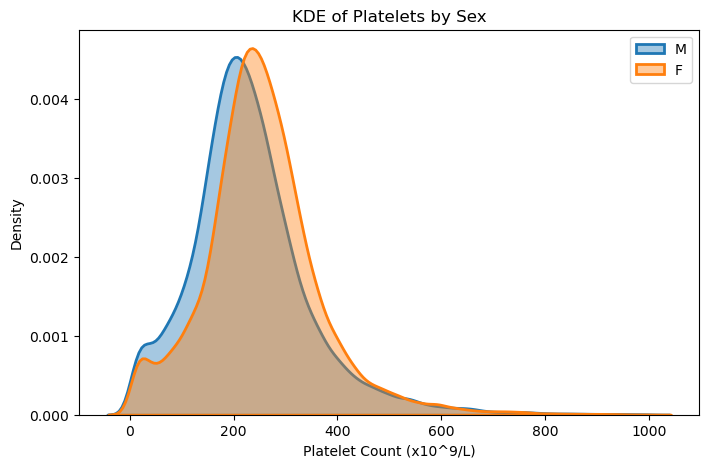

In [13]:
plot_platelets_by_sex(df_platelets)

##### Figura 5

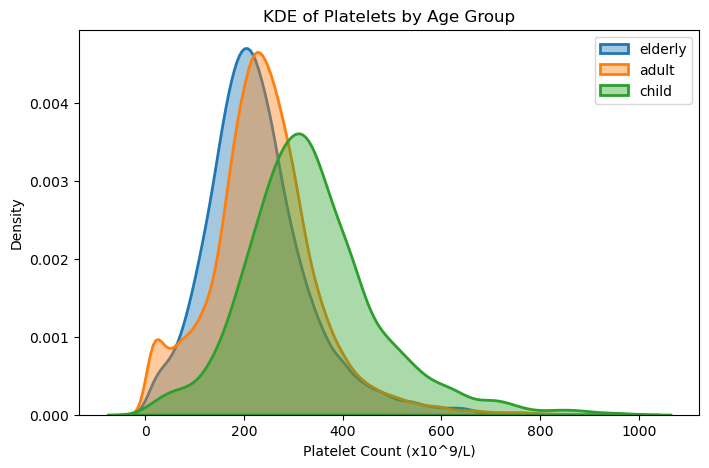

In [14]:
plot_platelets_by_age_group(df_platelets)

##### Figura 6

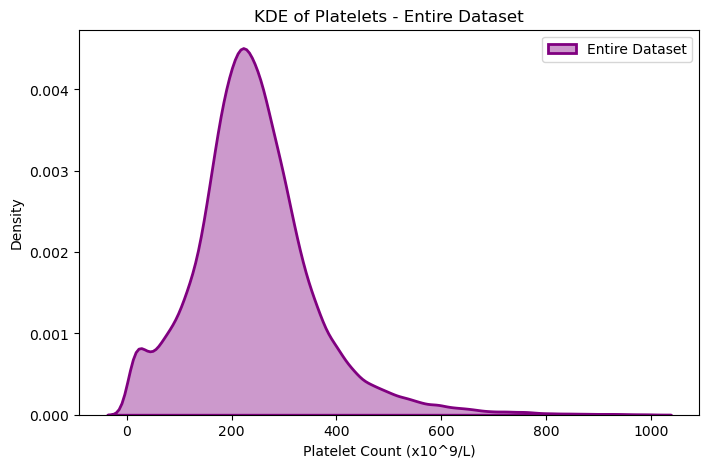

In [15]:
plot_platelets_entire_dataset(df_platelets)

##### Tabela 1

In [16]:
def filter_platelets(df, max_value=1000):
    """Filter platelet values <= max_value"""
    return df[df["value"] <= max_value].copy()


def calculate_ci(data, percentile, confidence=0.95):
    """Calculate confidence interval for a given percentile"""
    n = len(data)
    if n < 2:
        return np.nan, np.nan

    p_value = np.percentile(data, percentile)
    sorted_data = np.sort(data)
    p = percentile / 100

    # Standard error approximation
    se = np.sqrt(p * (1 - p) / n) * (sorted_data[-1] - sorted_data[0])
    z_score = stats.norm.ppf((1 + confidence) / 2)
    margin = z_score * se

    return max(0, p_value - margin), p_value + margin


def create_summary_row(data, group_name):
    """Create a summary row for a group"""
    n = len(data)
    if n == 0:
        return {
            "Group": group_name,
            "n": 0,
            "mean (SD)": "NA",
            "2.5th-97.5th": "NA",
            "2.5th (95%CI)": "NA",
            "97.5th (95%CI)": "NA",
        }

    mean_val = np.mean(data)
    std_val = np.std(data, ddof=1)

    p2_5 = np.percentile(data, 2.5)
    p97_5 = np.percentile(data, 97.5)

    ci_2_5_lower, ci_2_5_upper = calculate_ci(data, 2.5)
    ci_97_5_lower, ci_97_5_upper = calculate_ci(data, 97.5)

    return {
        "Group": group_name,
        "n": n,
        "mean (SD)": f"{mean_val:.0f} ({std_val:.1f})",
        "2.5th-97.5th": f"{p2_5:.0f}–{p97_5:.0f}",
        "2.5th (95%CI)": f"{ci_2_5_lower:.0f}–{ci_2_5_upper:.0f}",
        "97.5th (95%CI)": f"{ci_97_5_lower:.0f}–{ci_97_5_upper:.0f}",
    }


def generate_summary(df):
    """Generate summary rows for all age/sex groups"""
    df_platelets = filter_platelets(df)

    summary_rows = []

    # <15 years (All children)
    children_data = df_platelets[df_platelets["age_group"] == "child"]["value"]
    summary_rows.append(create_summary_row(children_data, "All"))

    # 15-64 years
    adult_men = df_platelets[
        (df_platelets["age_group"] == "adult") & (df_platelets["sex"] == "M")
    ]["value"]
    adult_women = df_platelets[
        (df_platelets["age_group"] == "adult") & (df_platelets["sex"] == "F")
    ]["value"]

    summary_rows.append(create_summary_row(adult_men, "Men"))
    summary_rows.append(create_summary_row(adult_women, "Women"))

    # >64 years
    elderly_men = df_platelets[
        (df_platelets["age_group"] == "elderly") & (df_platelets["sex"] == "M")
    ]["value"]
    elderly_women = df_platelets[
        (df_platelets["age_group"] == "elderly") & (df_platelets["sex"] == "F")
    ]["value"]

    summary_rows.append(create_summary_row(elderly_men, "Men"))
    summary_rows.append(create_summary_row(elderly_women, "Women"))

    return pd.DataFrame(summary_rows)


def print_summary_table(summary_rows):
    """Pretty-print the summary table"""
    print("Platelet Summary Statistics")
    print("=" * 80)
    print()
    print(
        f"{'Age':<12} {'n':<8} {'mean':<12} {'2.5th–':<12} "
        f"{'2.5th':<12} {'97.5th':<12}"
    )
    print(
        f"{'':12} {'':8} {'(SD)':<12} {'97.5th':<12} "
        f"{'(95%CI)':<12} {'(95%CI)':<12}"
    )
    print("-" * 80)

    # <15 years
    print("<15 years\n")
    row = summary_rows.iloc[0]
    print(
        f"{'All':<12} {row['n']:<8} {row['mean (SD)']:<12} "
        f"{row['2.5th-97.5th']:<12} {row['2.5th (95%CI)']:<12} "
        f"{row['97.5th (95%CI)']:<12}"
    )

    # 15-64 years
    print("\n15-64 years\n")
    for i in [1, 2]:
        row = summary_rows.iloc[i]
        print(
            f"{row['Group']:<12} {row['n']:<8} {row['mean (SD)']:<12} "
            f"{row['2.5th-97.5th']:<12} {row['2.5th (95%CI)']:<12} "
            f"{row['97.5th (95%CI)']:<12}"
        )

    # >64 years
    print("\n>64 years\n")
    for i in [3, 4]:
        row = summary_rows.iloc[i]
        print(
            f"{row['Group']:<12} {row['n']:<8} {row['mean (SD)']:<12} "
            f"{row['2.5th-97.5th']:<12} {row['2.5th (95%CI)']:<12} "
            f"{row['97.5th (95%CI)']:<12}"
        )

    print("\nSD, standard deviation; CI, confidence interval.")


# === Example usage ===
# summary_df = generate_summary(df)
# print_summary_table(summary_df)

### Modelo de síntese

Para a síntese dos dados, foi utilizado o modelo de cópula gaussiana, uma técnica que permite modelar a dependência entre variáveis de diferentes escalas e distribuições enquanto se preserva a distribuição marginal de cada variável [3]. Esta habilidade de capturar as características intrínsecas e extrínsecas dos dados originais o torna ideal para este trabalho. Utilizou-se a implementação disponível na biblioteca `sdv`, que oferece uma interface simples para treinar o modelo e gerar dados sintéticos.

Abaixo está a função principal, `generate_synthetic_data`, que recebe o DataFrame original e os parâmetros de configuração, como a opção de remover outliers e o número de amostras a serem geradas. Ela retorna um DataFrame com os dados sintéticos gerados pelo modelo de cópula gaussiana, com a estrutura dos dados preservada. Já a função `export_synthetic_data` salva os dados sintéticos em um arquivo CSV, formatando os valores conforme necessário.

Para simplificar a sintetização, cada amostra gerada é de um paciente único, ou seja não possuem relação temporal entre si nem com o conjunto de dados original. Isto é feito para evitar a complexidade de modelar dependências temporais, já que apenas 18% dos pacientes possuem mais de um exame realizado, e apenas 8% deles possuem mais de dois exames.

In [17]:
id_value_counts = df.id.value_counts()

print(f"Number of patients with more than one exam: {len(id_value_counts[id_value_counts > 1])} ({len(id_value_counts[id_value_counts > 1]) / len(id_value_counts) * 100:.2f}%)")   
print(f"Number of patients with more than two exams: {len(id_value_counts[id_value_counts > 2])} ({len(id_value_counts[id_value_counts > 2]) / len(id_value_counts) * 100:.2f}%)")

Number of patients with more than one exam: 11562 (37.41%)
Number of patients with more than two exams: 5552 (17.96%)


In [18]:
def build_age_references(df: pd.DataFrame) -> dict:
    """
    Build a dictionary mapping (age_group, sex) -> np.ndarray of ages.
    """
    return (
        df.groupby(["age_group", "sex"])["age"]
        .apply(lambda x: x.values)
        .to_dict()
    )


def sample_group_fast(group: pd.DataFrame, age_references: dict) -> pd.Series:
    """
    Sample ages for a single group using fast integer indexing.
    """
    ref = age_references[(group.name[0], group.name[1])]
    idx = np.random.randint(0, len(ref), size=len(group))
    return pd.Series(ref[idx], index=group.index)


def generate_synthetic_ages(
    synthetic_df: pd.DataFrame, age_references: dict
) -> pd.DataFrame:
    """
    Generate synthetic ages for each (age_group, sex) in synthetic_df
    using the provided age_references.
    """
    synthetic_df = synthetic_df.copy()
    synthetic_df["age"] = synthetic_df.groupby(
        ["age_group", "sex"], group_keys=False
    ).apply(lambda g: sample_group_fast(g, age_references))
    return synthetic_df

In [19]:
metadata = SingleTableMetadata()
metadata.add_column(column_name="age", sdtype="numerical")
metadata.add_column(column_name="sex", sdtype="categorical")
metadata.add_column(column_name="value", sdtype="numerical")

def generate_synthetic_data(df, remove_outliers=False, num_samples=None):
  """
  Generate synthetic platelet data using Gaussian Copula.
  
  Parameters
  ----------
  df : pd.DataFrame
    Original dataframe with columns: age, sex, value, age_group
  remove_outliers : bool, default=False
    Whether to remove outliers using log-IQR method
  num_samples : int, optional
    Number of synthetic samples to generate. If None, uses same size as input.
  
  Returns
  -------
  pd.DataFrame
    Synthetic dataframe with columns: timestamp, id, age, sex, value, age_group
  """
  copula_df = df.copy()
  
  # Remove outliers if requested
  if remove_outliers:
    copula_df = remove_outliers_log_iqr(copula_df, column='value', multiplier=1)
  
  # Prepare data for model
  copula_df["sex"] = copula_df["sex"].astype("object")

  model = GaussianCopulaSynthesizer(metadata)

  # Train model
  model.fit(copula_df[["age", "sex", "value"]])

  # Generate synthetic data
  if num_samples is None:
    num_samples = len(copula_df)
  
  synthetic_df = model.sample(num_rows=num_samples)
  
  # Add timestamp column starting from last timestamp in original data
  last_timestamp = df['timestamp'].max()
  synthetic_df['timestamp'] = pd.date_range(
    start=last_timestamp + pd.Timedelta(hours=1),
    periods=num_samples,
    freq='h'
  )
  
  # Add unique id column avoiding existing ids
  existing_ids = set(df['id'].unique())
  available_ids = [i for i in range(100000000) if str(i) not in existing_ids]
  synthetic_df['id'] = np.random.choice(available_ids, size=num_samples, replace=False).astype(str)
  synthetic_df['anolyte'] = "PLAQUETAS SANGUE"
  copula_df['anolyte'] = "PLAQUETAS SANGUE"
  
  # Reorder columns to match original structure
  original_columns = ['timestamp', 'age', 'id', 'sex', 'anolyte', 'value']
  synthetic_df = synthetic_df[original_columns]
  copula_df = copula_df[original_columns]
  
  return copula_df, synthetic_df

def export_synthetic_data(synthetic_df: pd.DataFrame, file_path: str):
    """
    Export synthetic data to a CSV file.
    
    Parameters
    ----------
    synthetic_df : pd.DataFrame
        DataFrame containing synthetic data.
    file_path : str
        Path to save the CSV file.
    """
    export_df = synthetic_df.copy()
    export_df['timestamp'] = export_df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
    export_df['value'] = export_df['value'].astype(str).str.replace('.', ',', regex=False)
    export_df.to_csv(file_path, index=False, header=False, columns=['timestamp', 'age', 'id', 'sex', 'anolyte', 'value'])
    print(f"Synthetic data exported to {file_path}")

# Generate synthetic data
copula_df, synthetic_df = generate_synthetic_data(df)

export_synthetic_data(synthetic_df, 'synthetic_platelets.csv')

/home/kris/miniforge3/envs/torch/lib/python3.11/site-packages/sdv/single_table/base.py:167: FutureWarning:

The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.

/home/kris/miniforge3/envs/torch/lib/python3.11/site-packages/sdv/single_table/base.py:133: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.



Synthetic data exported to synthetic_platelets.csv


## Resultados

A célula abaixo mostra a validação das propriedade intrínsecas dos dados sintéticos, utilizando a função `run_diagnostic` da biblioteca `sdv`. Ela faz quatro verificações:
1. Verifica a estrutura das colunas, garantindo que os tipos de dados e nomes das colunas estejam corretos.
2. Verifica os domínios válidos de cada coluna, garantindo que os valores estejam dentro dos limites esperados.
3. Verifica a unicidade dos identificadores, garantindo que não haja duplicatas.
4. Verifica que as as colunas categóricas possuam os mesmos valores únicos.

A saída da célula mostra que todas as verificações foram aprovadas, indicando que os dados sintéticos possuem a estrutura correta e respeitam os limites esperados.

Já a tabela 2 e 3 mostram os resultados quantitativos da avaliação das propriedades extrínsecas dos dados sintéticos. A tabela 2 mostra os resultados das distribuições marginais, enquanto a tabela 3 mostra os resultados das distribuições conjuntas. As métricas de KS e TVD foram substituídas por 1 menos o valor original, para que valores mais altos indiquem melhor qualidade. Ambas as tabelas mostram que os dados sintéticos preservam bem as propriedades dos dados originais, com similaridade média de 97% para distribuições marginais e 95% para distribuições conjuntas, totalizando uma similaridade geral de 94%.

As figuras 7, 8 e 9 mostram as distribuições marginais e conjuntas dos dados sintéticos em comparação com os dados originais. A figura 7 mostra a distribuição de sexos, a figura 8 mostra a distribuição de idades e a figura 9 mostra a distribuição conjunta de idade e plaquetas. Percebe-se uma desvio padrão maior nos dados sintéticos, e as categorias de idade e sexo estão menos distintas. Isso pode ser atribuído à natureza probabilística do modelo de cópula gaussiana, que tende a suavizar as distribuições ao gerar novos dados. No entanto, as principais características das distribuições são preservadas, indicando que o modelo capturou bem as propriedades dos dados originais.

In [20]:
from sdv.evaluation.single_table import run_diagnostic

diagnostic_report = run_diagnostic(
    real_data=copula_df,
    synthetic_data=synthetic_df,
    metadata=metadata)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 3/3 [00:00<00:00, 82.27it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 130.13it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



#### Tabela 2

In [21]:
eval_cols = ["age", "sex", "value"]

quality_report = evaluate_quality(
    copula_df[eval_cols],
    synthetic_df[eval_cols],
    metadata,
    verbose=False
)

column_shapes = quality_report.get_details('Column Shapes')

print(f"Column Shapes Score: {column_shapes.Score.mean() * 100:.2f}%")
column_shapes

Column Shapes Score: 97.06%


,Column,Metric,Score
0,age,KSComplement,0.970093
1,sex,TVComplement,0.999036
2,value,KSComplement,0.942619


#### Tabela 3

In [22]:
sex_value_metric = ContingencySimilarity.compute(
    real_data=copula_df[['value', 'sex']],
    synthetic_data=synthetic_df[['value', 'sex']],
    num_discrete_bins=100,
    continuous_column_names=['value'],
)

sex_age_metric = ContingencySimilarity.compute(
    real_data=copula_df[['age', 'sex']],
    synthetic_data=synthetic_df[['age', 'sex']],
    num_discrete_bins=100,
    continuous_column_names=['age'],
)


age_value_metric = CorrelationSimilarity.compute(
    real_data=copula_df[['age', 'value']],
    synthetic_data=synthetic_df[['age', 'value']]
)

# Create a comparison metrics dataframe
comparison_metrics = pd.DataFrame({
    'Column 1': ['value', 'age', 'age'],
    'Column 2': ['sex', 'sex', 'value'],
    'Metric': ['ContingencySimilarity', 'ContingencySimilarity', 'CorrelationSimilarity'],
    'Score': [sex_value_metric, sex_age_metric, age_value_metric]
})

print(f"Column Pair Score: {comparison_metrics['Score'].mean() * 100:.2f}%")
comparison_metrics

Column Pair Score: 92.38%


,Column 1,Column 2,Metric,Score
0,value,sex,ContingencySimilarity,0.873594
1,age,sex,ContingencySimilarity,0.907609
2,age,value,CorrelationSimilarity,0.990187


In [23]:
print(f"Mean Overall Score: {(column_shapes.Score.mean() + comparison_metrics.Score.mean()) / 2 * 100:.2f}%")

Mean Overall Score: 94.72%


#### Figura 7

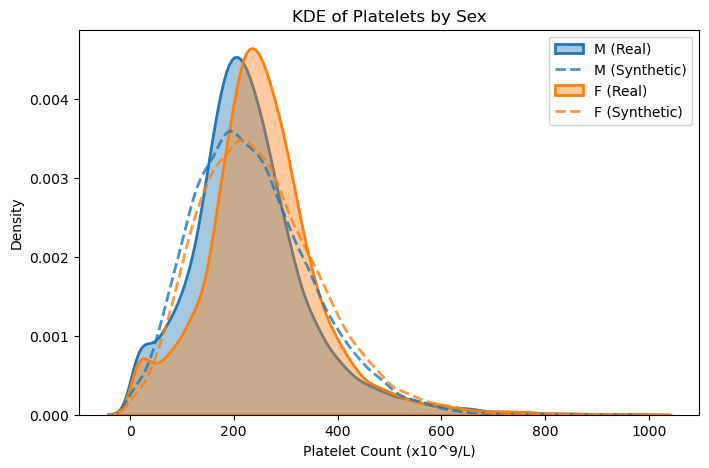

In [24]:
# add age groups for visualizations
add_age_group(synthetic_df)
add_age_group(copula_df)

df_synth_platelets = preprocess_platelets(synthetic_df)
df_copula_platelets = preprocess_platelets(copula_df)
plot_platelets_by_sex(df_copula_platelets, df_synth_platelets)

#### Figura 8

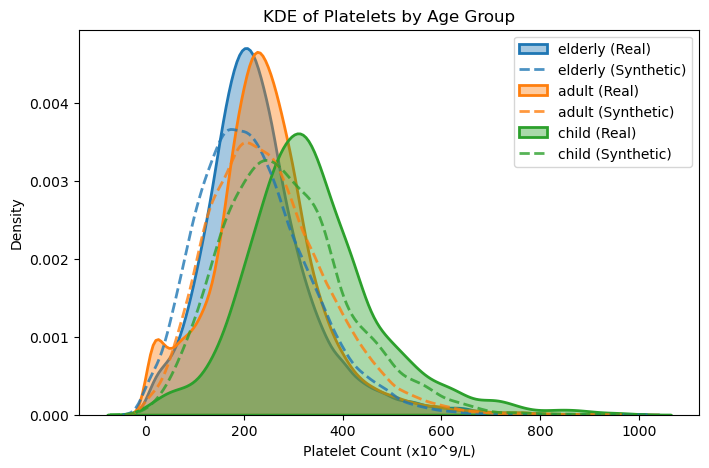

In [25]:
plot_platelets_by_age_group(df_copula_platelets, df_synth_platelets)

#### Figura 9

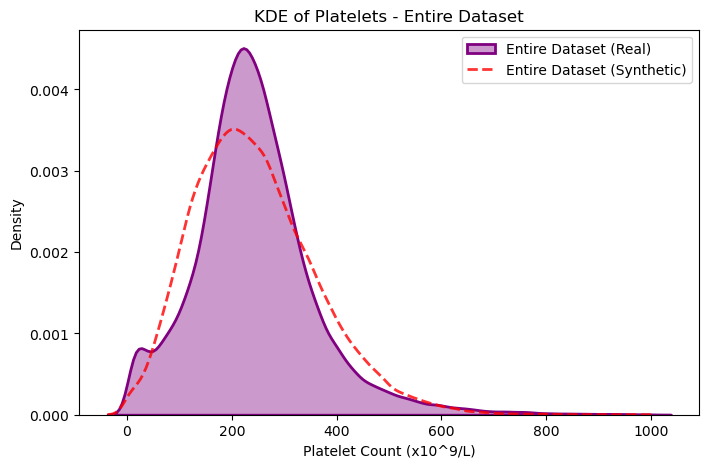

In [26]:
plot_platelets_entire_dataset(df_copula_platelets, df_synth_platelets)

## Discussão

Os resultados mostram que o modelo de cópula gaussiana é capaz de gerar dados sintéticos realistas, preservando tanto as propriedades intrínsecas quanto extrínsecas dos dados originais. A validação das propriedades intrínsecas indica que os dados sintéticos possuem a estrutura correta e respeitam os limites esperados. Já a avaliação das propriedades extrínsecas mostra que as distribuições marginais e conjuntas são bem preservadas, com similaridade média de 97% e 95%, respectivamente. No entanto, o modelo apresenta um desvio padrão maior nas distribuições marginais, o que pode ser atribuído à natureza probabilística do modelo de cópula gaussiana. A remoção de outliers ajuda o modelo a obter melhores resultados, mas limita a capacidade de capturar casos extremos, o que pode ser desejável em alguns contextos.

Além disso, o método proposto se limitou a sintetizar dados de um único tipo de exame sem levar em conta a temporalidade entre exames do mesmo paciente, o que limita o realismo. Pesquisas futuras podem explorar a síntese de múltiplos tipos de exames, levando em consideração as relações temporais entre eles, utilizando modelos sequenciais como conditional probabilistic models (CPMs) ou redes neurais recorrentes (RNNs).

## Bibliografia

1. [Biino, G., Santimone, I., Minelli, C., Sorice, R., Frongia, B., Traglia, M., Ulivi, S., Di Castelnuovo, A., Gögele, M., Nutile, T., Francavilla, M., Sala, C., Pirastu, N., Cerletti, C., Iacoviello, L., Gasparini, P., Toniolo, D., Ciullo, M., Pramstaller, P., Pirastu, M., … Balduini, C. L. (2013). Age- and sex-related variations in platelet count in Italy: A proposal of reference ranges based on 40987 subjects' data. *PLOS ONE*, *8*(1), 1–7.](https://doi.org/10.1371/journal.pone.0054289)

2. [Simmonds, J., Dube, K., Gallagher, T., Fenton, N., & McLachlan, S. (2019). Realistic Synthetic Data Generation: The ATEN Framework.](https://www.researchgate.net/publication/325824760_Realistic_Synthetic_Data_Generation_The_ATEN_Framework)
3. [Song, P. X.-K. (2000). Multivariate Dispersion Models Generated from Gaussian Copula. Scandinavian Journal of Statistics, 27(2), 305–320.](http://www.jstor.org/stable/4616605)